<a href="https://colab.research.google.com/github/meritcthomas/TESI-Management/blob/master/03_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Use seaborn for pairplot
!pip install seaborn

# Use some functions from tensorflow_docs
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-_o60mwxv
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-_o60mwxv
     |████████████████████████████████| 1.0MB 5.3MB/s 
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.07709fc2909067eb0f213c262669e4c54299ff5d4_-cp37-none-any.whl size=150538 sha256=133f22c67717a1fa0b843c4c1d926d7847c0cb2e4ef710d2e716ed37f9345ccb
  Stored in directory: /tmp/pip-ephem-wheel-cache-9sjhp3s5/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs
  Found existing installation: protobuf 3.12.4
    Uninstalling protobuf-3.12.4:
      Successfully uninstalled protobuf-3.12.4


In [ ]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.4.1


In [ ]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [ ]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/root/.keras/datasets/auto-mpg.data'

In [ ]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [ ]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [ ]:
dataset = dataset.dropna()

In [ ]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [ ]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [ ]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

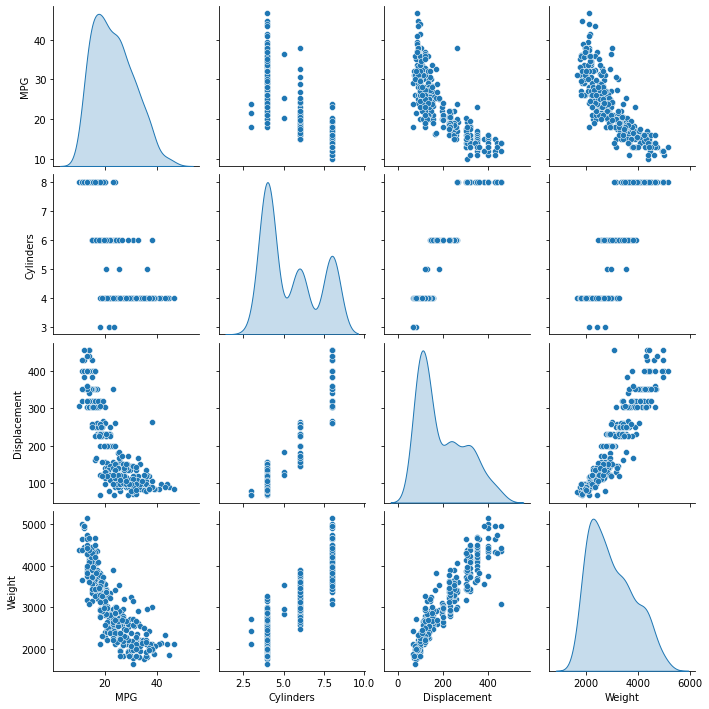

In [ ]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [ ]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [ ]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [ ]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(128, activation='relu'),
    layers.Dense(64,activation ='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [ ]:
?tf.keras.optimizers.RMSprop

In [ ]:
model = build_model()

In [ ]:
params_count = (9+1)*64 + (64+1)*128 + (128+1)*64 + (64+1)*1
params_count

17281

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 17,281
Trainable params: 17,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
EPOCHS = 300

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=2,
  callbacks=[tfdocs.modeling.EpochDots()])

Epoch 1/1000
8/8 [==============================] - 0s 13ms/step - loss: 0.7670 - mae: 0.6293 - mse: 0.7670 - val_loss: 12.6737 - val_mae: 2.7597 - val_mse: 12.6737

Epoch: 0, loss:0.7670,  mae:0.6293,  mse:0.7670,  val_loss:12.6737,  val_mae:2.7597,  val_mse:12.6737,  
.Epoch 2/1000
8/8 [==============================] - 0s 13ms/step - loss: 0.7716 - mae: 0.6623 - mse: 0.7716 - val_loss: 11.0221 - val_mae: 2.5054 - val_mse: 11.0221
.Epoch 3/1000
8/8 [==============================] - 0s 14ms/step - loss: 1.3953 - mae: 0.7892 - mse: 1.3953 - val_loss: 11.5964 - val_mae: 2.6274 - val_mse: 11.5964
.Epoch 4/1000
8/8 [==============================] - 0s 14ms/step - loss: 0.4582 - mae: 0.3939 - mse: 0.4582 - val_loss: 11.5269 - val_mae: 2.5459 - val_mse: 11.5269
.Epoch 5/1000
8/8 [==============================] - 0s 14ms/step - loss: 0.9081 - mae: 0.7071 - mse: 0.9081 - val_loss: 11.9485 - val_mae: 2.5729 - val_mse: 11.9485
.Epoch 6/1000
8/8 [==============================] - 0s 14ms/step

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,0.704409,0.545918,0.704409,12.340481,2.609753,12.340481,995
996,0.238261,0.361337,0.238261,12.445887,2.587364,12.445887,996
997,0.436522,0.507964,0.436522,13.210463,2.582873,13.210463,997
998,0.543599,0.525338,0.543599,13.344145,2.585213,13.344145,998
999,0.188409,0.313481,0.188409,12.726070,2.683214,12.726070,999


In [ ]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [MPG]')

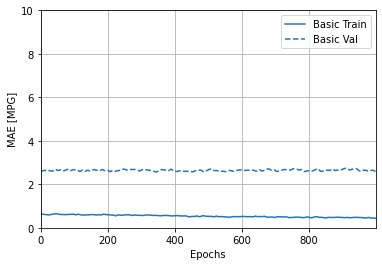

In [ ]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

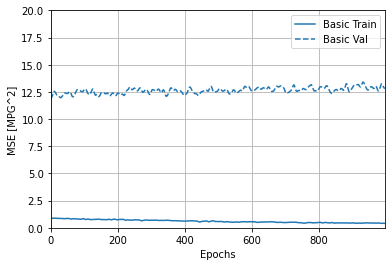

In [ ]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

In [ ]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:542.3629,  mae:21.9270,  mse:542.3629,  val_loss:474.3615,  val_mae:20.2608,  val_mse:474.3615,  
...................................................................................

In [ ]:
hist = pd.DataFrame(early_history.history)
hist['epoch'] = early_history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
78,5.558147,1.634688,5.558147,11.819895,2.632452,11.819895,78
79,5.937181,1.857470,5.937181,9.816057,2.392242,9.816057,79
80,5.853393,1.707014,5.853393,8.236406,2.246032,8.236406,80
81,5.058353,1.557957,5.058353,8.270525,2.174359,8.270525,81
82,5.407013,1.628432,5.407013,8.354086,2.254427,8.354086,82


Text(0, 0.5, 'MAE [MPG]')

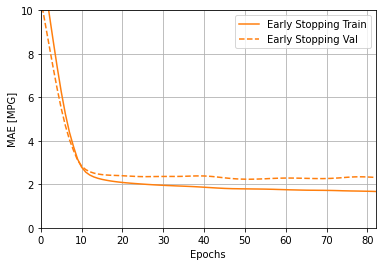

In [ ]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 6.3270 - mae: 1.8592 - mse: 6.3270
Testing set Mean Abs Error:  1.86 MPG


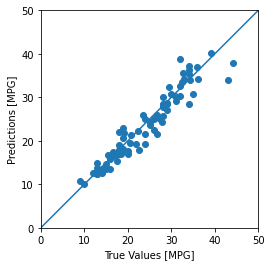

In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


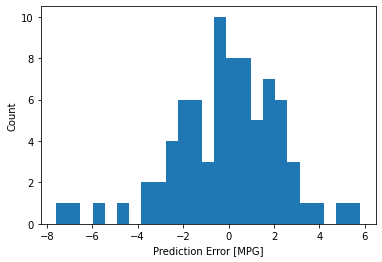

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")